# Gerando sprites laterais com Pix2Pix

.

Este _notebook_ é parte do trabalho [pixel sides](pixel-sides.ipynb). Ele descreve um experimento de criação de 
um modelo de redes generativas adversariais baseado na arquitetura [Pix2Pix][p2p-artigo] (Isola et al, 2017)
para tentar gerar desenhos de um personagem em _pixel art_ virado para o lado direito dada sua imagem de frente:

![center](docs/tiny-hero-front-to-right.png)

[p2p-artigo]: https://arxiv.org/pdf/1611.07004.pdf

A arquitetura Pix2Pix contempla redes neurais convolucionais condicionais profundas (cDCGAN) que
aprendem o mapeamento de um conjunto de imagens para seus pares.
Ela é composta por uma rede generativa e outra discriminadora e já foi usada para diversas aplicações
com bons resultados e dispensando engenharia manual da arquitetura para adequar às especificidades
dos problemas.

In [111]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [112]:
seed = 42
np.random.seed(seed)

DATA_FOLDER = "tiny-hero"
DIRECTION_FOLDERS = ["0-back", "1-left", "2-front", "3-right"]

DATASET_SIZE = 912
TRAIN_SIZE = int(DATASET_SIZE * 0.75)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE

BUFFER_SIZE = DATASET_SIZE
BATCH_SIZE = 1

IMG_SIZE = 64
CHANNELS = 4

## Carregando o _dataset_ pareado

A entrada para uma rede seguindo a arquitetura Pix2Pix é um conjunto de dados em que cada entrada
possui uma imagem de entrada e outra de objetivo. A rede original recebe e gera imagens $(256, 256, 3)$.
Contudo, a rede implementada aqui processa imagens de $(64, 64, 4)$.

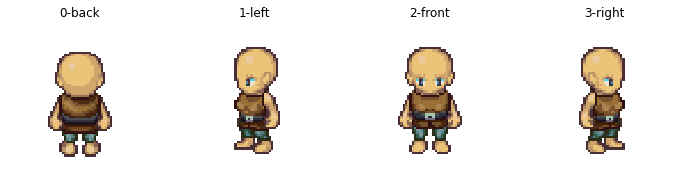

In [113]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image)
    image = tf.cast(image, tf.float32)
    return image

def load_sprite(file_index, folders):
    images = [load_image(os.path.join(folder, f"{file_index}.png")) for folder in folders]
    return (images[0], images[1], images[2], images[3])

sample_sprite = load_sprite(1, list(map(lambda df: os.path.join(DATA_FOLDER, df), DIRECTION_FOLDERS)))
plt.figure(figsize=(12,3))
for j in range(4):
    plt.subplot(1, 4, j+1)
    plt.title(DIRECTION_FOLDERS[j])
    plt.imshow(sample_sprite[j] / 255, interpolation="nearest")
    plt.axis("off")
plt.show()

A arquitetura requer dados reescalados para a faixa $\{-1, +1\}$ e a provocação de leves 
perturbações envolvendo (a) translações e (b) espelhamentos. Contudo, na rede implementada aqui
essas operações não foram realizadas pela característica de todas as imagens estarem perfeitamente
centralizadas, se tratarem de _pixel art_ e a alteração da pose ser negativamente impactada por espelhamentos.

In [136]:
# rescala imagens entre [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

Caso essa perturbação fosse implementada as perturbações podem se parecer com estes:

![](docs/pix2pix-random-jitter.png)

Os _datasets_ foram então criados pareando imagens na **pose frente para a pose direita**:

In [115]:
def create_image_train_loader(sprite_side_source, sprite_side_target):
    def load_image_train(image_number):
        image_number = tf.strings.as_string(image_number)
        input_image = load_image(tf.strings.join([DATA_FOLDER, "\\", DIRECTION_FOLDERS[sprite_side_source], "\\", image_number, ".png"]))
        real_image = load_image(tf.strings.join([DATA_FOLDER, "\\", DIRECTION_FOLDERS[sprite_side_target], "\\", image_number, ".png"]))
        input_image, real_image = normalize(input_image, real_image)
        return input_image, real_image
    return load_image_train

def create_image_test_loader(sprite_side_source, sprite_side_target):
    def load_image_test(image_number):
        image_number = tf.strings.as_string(image_number)
        input_image = load_image(tf.strings.join([DATA_FOLDER, "\\", DIRECTION_FOLDERS[sprite_side_source], "\\", image_number, ".png"]))
        real_image = load_image(tf.strings.join([DATA_FOLDER, "\\", DIRECTION_FOLDERS[sprite_side_target], "\\", image_number, ".png"]))
        input_image, real_image = normalize(input_image, real_image)
        return input_image, real_image
    return load_image_test

In [116]:
full_files_dataset = tf.data.Dataset.range(DATASET_SIZE)
train_dataset = full_files_dataset.take(TRAIN_SIZE)
test_dataset = full_files_dataset.skip(TRAIN_SIZE)

f2r_train_dataset = train_dataset.map(create_image_train_loader(2, 3), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.shuffle(BUFFER_SIZE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)

f2r_test_dataset = test_dataset.map(create_image_test_loader(2, 3))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)



## Rede Geradora

Assim como na arquitetura Pix2Pix, a rede geradora foi criada seguindo o modelo U-net em que as primeiras camadas
reduzem a dimensionalidade espacial até o tamanho $1$ e as últimas aumentam de volta para o tamanho original.
Há _skip-connections_ entre as primeiras e as últimas camadas.

A quantidade de camadas foi reduzida para se adequar à entrada com dimensões $(64, 64)$ em vez de $(256, 256)$.
Como cada camada de redução de dimensionalidade (_downsampling_) divide cada dimensão por 2:

$$camadas=log\left|entrada\right|$$

Sendo assim, foram usadas 6 camadas de _downsampling_ em vez de 8 na arquitetura original.
As camadas de _upsampling_ também foram colocadas na mesma quantidade.

In [117]:
OUTPUT_CHANNELS = 4

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


(1, 32, 32, 4)


In [118]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding="same",
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


(1, 64, 64, 3)


In [119]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[64, 64, 4])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 32, 32, 64)
        downsample(128, 4),  # (batch_size, 16, 16, 128)
        downsample(256, 4),  # (batch_size, 8, 8, 256)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding="same",
                                         kernel_initializer=initializer,
                                         activation="tanh")  # (batch_size, 64, 64, 4)

    x = inputs

    # downsampling e adicionando as skip-connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # camadas de upsampling e skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



Testando a geração de imagem a partir de dados de entrada para verificar que dados estão sendo gerados e têm relação com a entrada.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


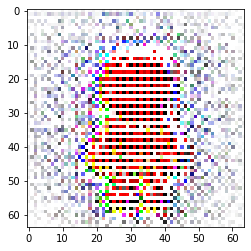

In [120]:
generator = Generator()
gen_output = generator(sample_sprite[0][tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

Função de perda do gerador:

In [121]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss



## Rede Discriminadora

A rede discriminadora seguiu arquitura de classificador convolucional via _patches_: em vez de considerar a imagem inteira, verifica pedaços de $(30, 30)$. Como é uma discriminadora, ela recebe imagens pareadas tanto dos dados de entrada quanto geradas pela rede geradora.



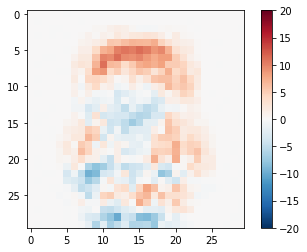

In [122]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[64, 64, 4], name="input_image")
    tar = tf.keras.layers.Input(shape=[64, 64, 4], name="target_image")

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 64, 64, channels*2)

    down = downsample(64, 4, False)(x)  # (batch_size, 32, 32, 64)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    
    conv = tf.keras.layers.Conv2D(128, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 128)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 128)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()

Função de perda do discriminador considera o que ele errou usando os dados reais e usando os dados provenientes da rede geradora.
A perda total é a soma:

In [123]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [124]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

In [125]:
checkpoint_dir = "./training_checkpoints/pix2pix"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [126]:
# invoca o gerador e mostra a imagem de entrada, sua imagem objetivo e a imagem gerada
def generate_images(model, test_input, tar, save_name=None):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Entrada", "Objetivo", "Imagem gerada"]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    
    if save_name != None:
        plt.savefig(save_name)
    
    plt.show()

## Treinamento e Avaliação

In [128]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "pix2pix/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [129]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step//1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step//1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step//1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step//1000)

In [130]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f"Tempo dos últimos 1.000 passos: {time.time()-start:.2f}s\n")

            start = time.time()

            save_image_name = "temp_side2side/image_at_step_{:06d}.png".format(step)
            generate_images(generator, example_input, example_target, save_image_name)
            print(f"Passo: {step//1000}k")

        train_step(input_image, target, step)

        # avisa que deu 10 passos de treinamento
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # salve um checkpoint do modelo a cada 5000 passos e uma imagem
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [132]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4068), started 0:43:41 ago. (Use '!kill 4068' to kill it.)

Tempo dos últimos 1.000 passos: 341.48s



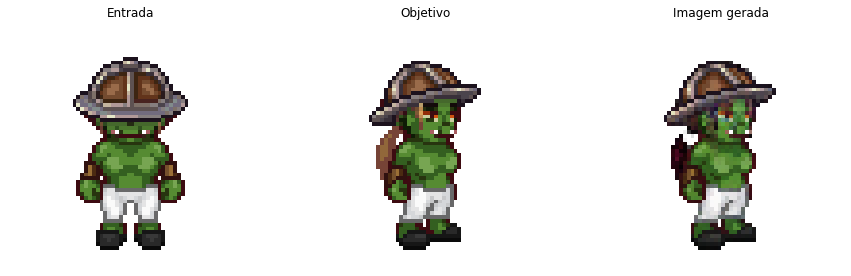

Passo: 99k
....................................................................................................

In [133]:
fit(f2r_train_dataset, f2r_test_dataset, steps=100000)


In [134]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

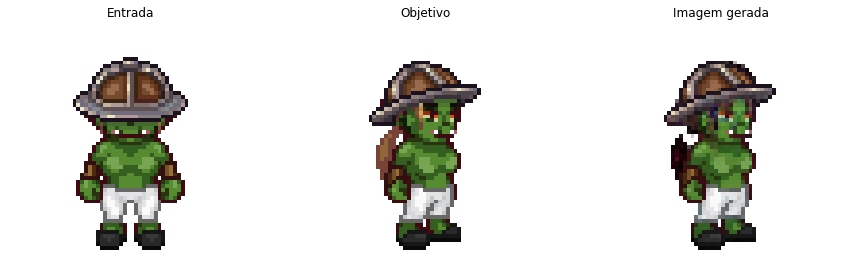

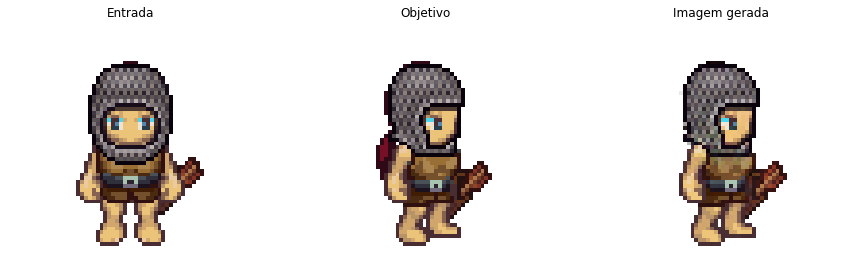

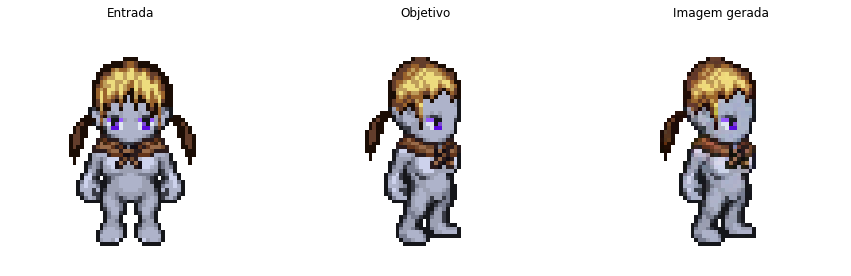

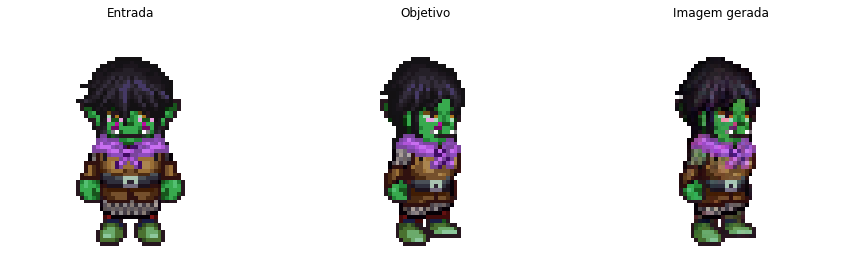

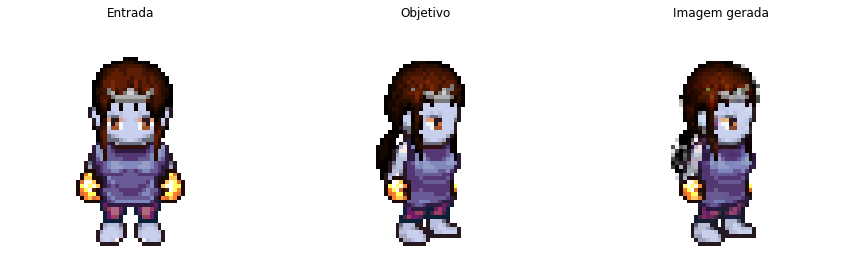

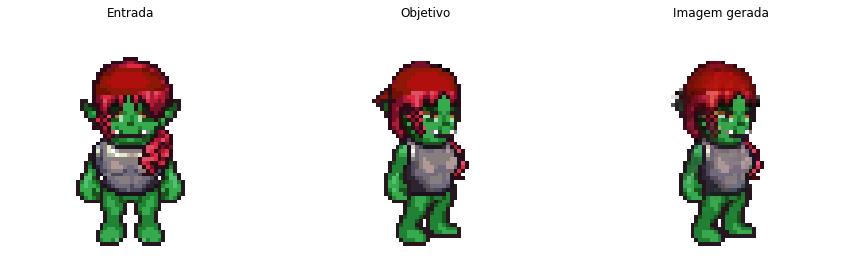

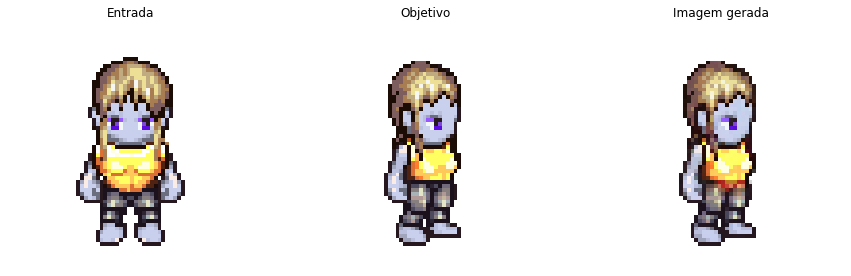

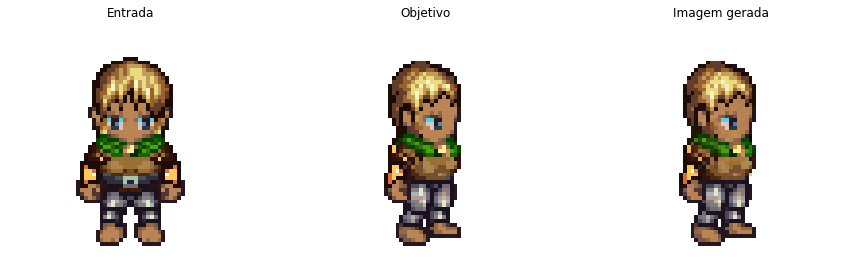

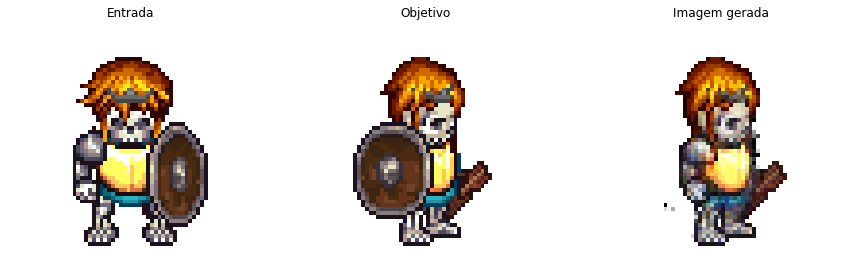

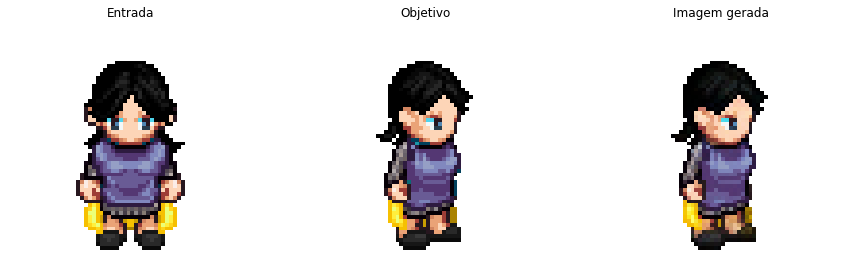

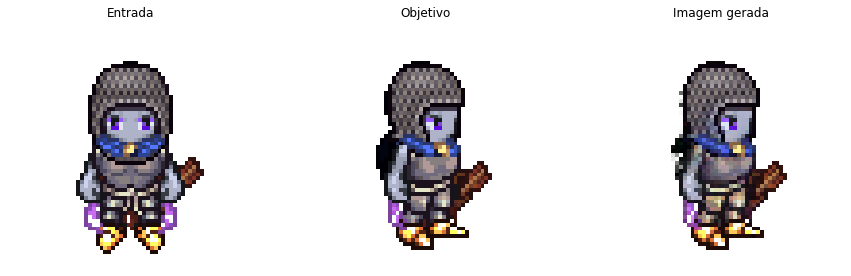

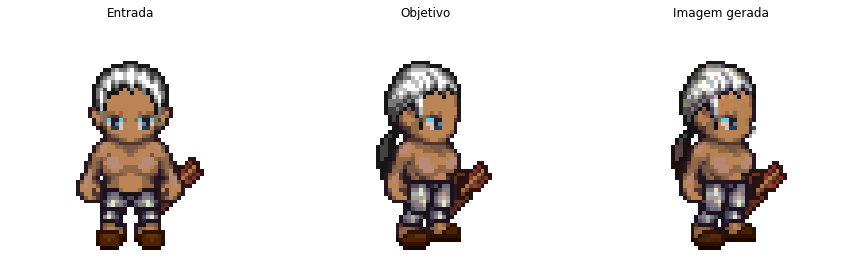

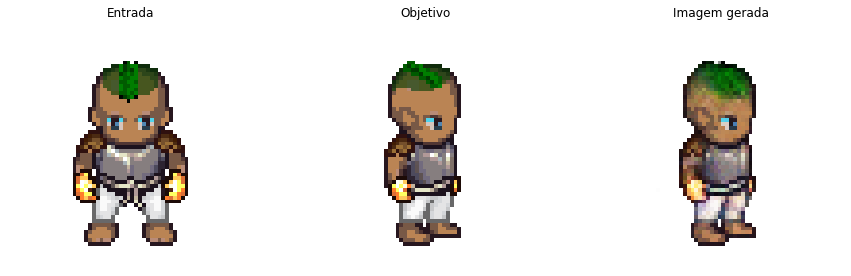

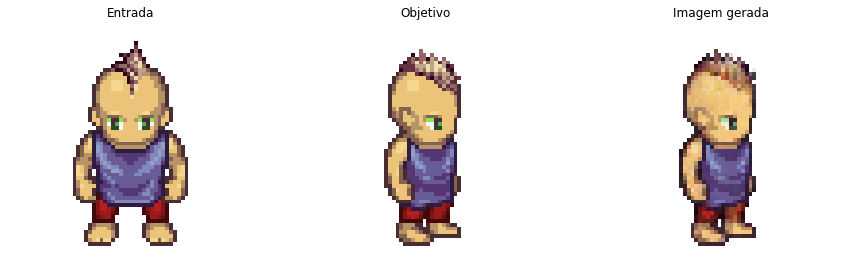

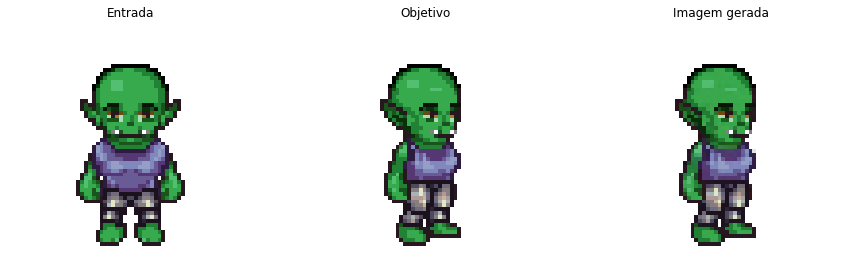

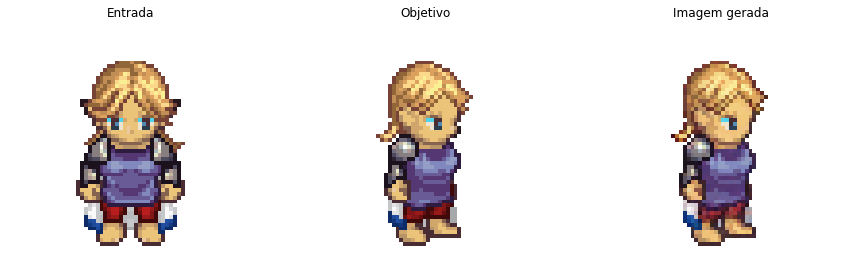

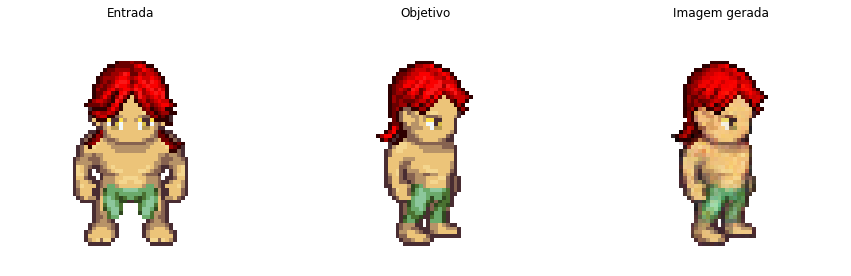

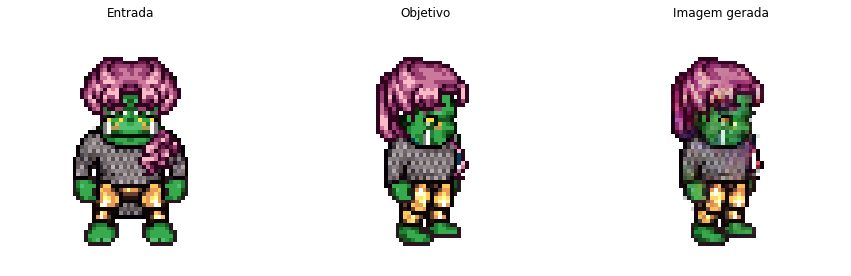

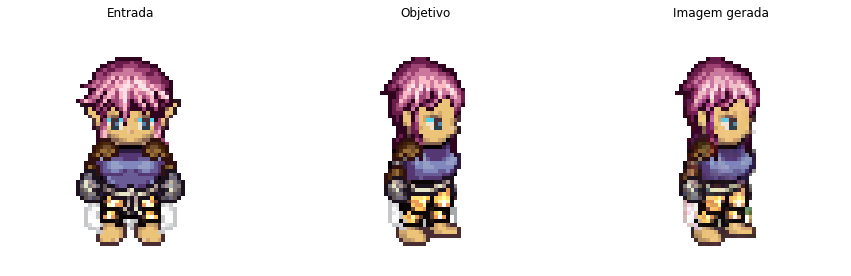

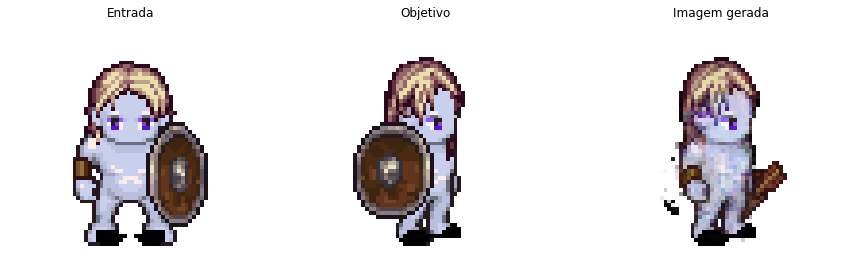

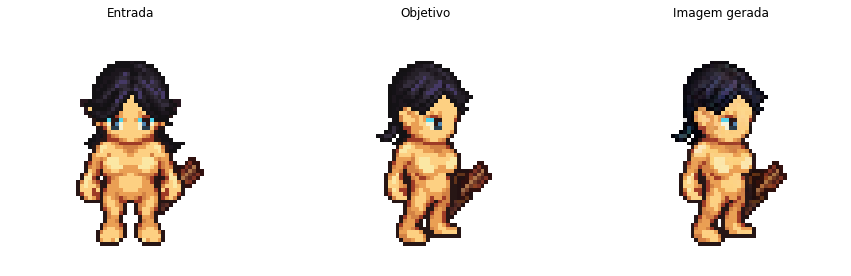

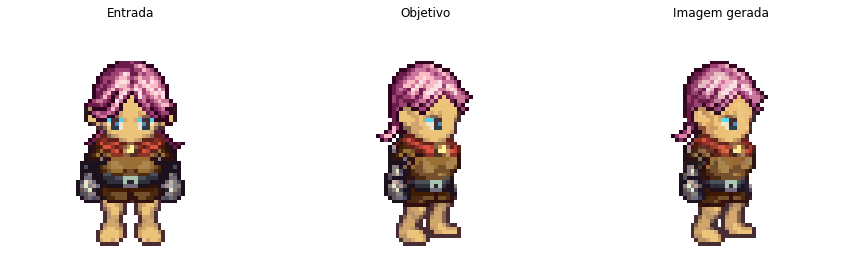

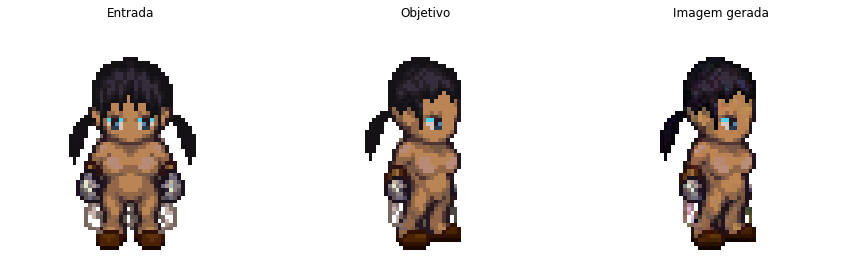

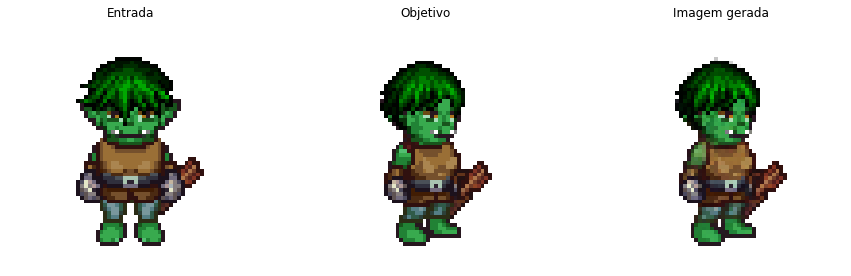

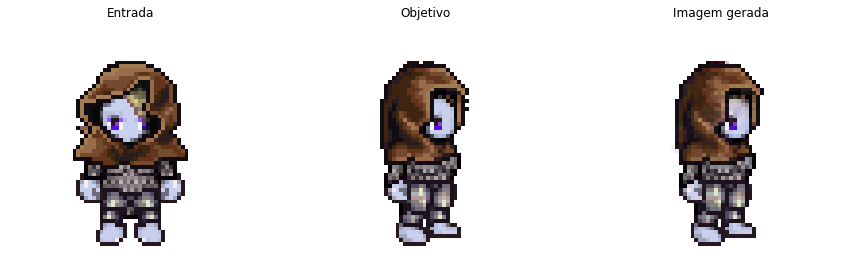

In [135]:
for inp, tar in f2r_test_dataset.take(25):
    generate_images(generator, inp, tar)